# HDB Resale Price Prediction

## Importing Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder

## Importing Dataset

In [59]:
flat_data_2012_2014 = 'data/raw/flat_data( Mar 2012 to Dec 2014).csv'
flat_data_2015_2016 = 'data/raw/flat_data(Jan 2015 to Dec 2016).csv'
flat_data_2017_onwards = 'data/raw/flat_data(Jan-2017 onwards).csv'
mrt = 'data/raw/MRT.geojson'

flat_data_2012_2014_df = pd.read_csv(flat_data_2012_2014)
flat_data_2015_2016_df = pd.read_csv(flat_data_2015_2016)
flat_data_2017_onwards_df = pd.read_csv(flat_data_2017_onwards)
mrt_gdf = gpd.read_file(mrt)

### Fetching Location Data

In [60]:
def get_coordinates(address):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    headers = {"Authorization": "Bearer **********************"}
    response = requests.get(url, headers=headers).json()

    if response['found'] > 0:
        lat = response['results'][0]['LATITUDE']
        lon = response['results'][0]['LONGITUDE']
        return lat, lon
    return None, None

# lat, lon = get_coordinates("Ang Mo Kio")

### Loading MRT Data

In [61]:
def extract_station_name(html_text):
    if pd.isna(html_text):
        return None
    soup = BeautifulSoup(html_text, "html.parser")

    station_row = soup.find("th", string="STATION_NA")
    if station_row:
        return station_row.find_next("td").text.strip()
    return None

mrt_gdf["station_name"] = mrt_gdf["Description"].apply(extract_station_name)
mrt_gdf["longitude"] = mrt_gdf.geometry.x
mrt_gdf["latitude"] = mrt_gdf.geometry.y

mrt_df = mrt_gdf[["station_name", "latitude", "longitude"]]

mrt_df.to_csv('data/clean_mrt_data.csv')

## Data Preprocessing

In [62]:
flat_data_2012_2014_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0


In [63]:
flat_data_2015_2016_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [64]:
flat_data_2017_onwards_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


### Data wrangling for "flat_data_2012_2014_df"

In [65]:
flat_data_2012_2014_df['month'] = pd.to_datetime(flat_data_2012_2014_df['month'], format='%Y-%m')
print(flat_data_2012_2014_df.dtypes)

month                  datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
resale_price                  float64
dtype: object


In [66]:
flat_data_2012_2014_df['remaining_lease'] =  (flat_data_2012_2014_df['lease_commence_date'] + 99)- flat_data_2012_2014_df['month'].dt.year

columns = flat_data_2012_2014_df.columns.to_list()
columns.remove('resale_price')
columns.append('resale_price')
flat_data_2012_2014_df = flat_data_2012_2014_df[columns]

flat_data_2012_2014_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2012-03-01,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0
1,2012-03-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0
2,2012-03-01,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,315000.0
3,2012-03-01,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,71,320000.0
4,2012-03-01,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,67,321000.0


In [67]:
flat_data_2012_2014_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

### Data wrangling for "flat_data_2015_2016_df"

In [68]:
flat_data_2012_2014_df['month'] = pd.to_datetime(flat_data_2012_2014_df['month'], format='%Y-%m')
print(flat_data_2012_2014_df.dtypes)

month                  datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
remaining_lease                 int64
resale_price                  float64
dtype: object


In [69]:
flat_data_2012_2014_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

### Data wrangling for "flat_data_2017_onwards_df"

In [70]:
flat_data_2017_onwards_df['month'] = pd.to_datetime(flat_data_2017_onwards_df['month'], format='%Y-%m')
print(flat_data_2017_onwards_df.dtypes)

month                  datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
remaining_lease                object
resale_price                  float64
dtype: object


In [71]:
flat_data_2017_onwards_df['remaining_lease'] = flat_data_2017_onwards_df['remaining_lease'].str[:2]
flat_data_2017_onwards_df['remaining_lease'] = flat_data_2017_onwards_df['remaining_lease'].astype('int')
flat_data_2017_onwards_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0


In [72]:
flat_data_2012_2014_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

### Combining all three DataFrame

In [73]:
hdb_df = pd.concat([flat_data_2012_2014_df, flat_data_2015_2016_df, flat_data_2017_onwards_df])
hdb_df['month'] = pd.to_datetime(hdb_df['month'])
hdb_df['town'] = hdb_df['town'].str.replace('KALLANG/WHAMPOA', 'KALLANG')
hdb_df = hdb_df.drop_duplicates()
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2012-03-01,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0
1,2012-03-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0
2,2012-03-01,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,315000.0
3,2012-03-01,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,71,320000.0
4,2012-03-01,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,67,321000.0


### Fetching Town Coordinates

In [74]:
unique_towns = hdb_df['town'].unique()
town_coordinates = {}

for town in unique_towns:
    town_coordinates[town] = get_coordinates(town)
    
hdb_df['latitude'] = hdb_df['town'].map(lambda x: town_coordinates[x][0])
hdb_df['longitude'] = hdb_df['town'].map(lambda x: town_coordinates[x][1])

columns = hdb_df.columns.to_list()
columns.remove('resale_price')
columns.append('resale_price')
hdb_df = hdb_df[columns]

### Finding each flat data with its nearest MRT Station

In [75]:
hdb_df = gpd.GeoDataFrame(hdb_df, geometry=gpd.points_from_xy(hdb_df["longitude"], hdb_df["latitude"]))
mrt_df = gpd.GeoDataFrame(mrt_df, geometry=gpd.points_from_xy(mrt_df["longitude"], mrt_df["latitude"]))

hdb_df = hdb_df.set_crs(epsg=4326)
mrt_df = mrt_df.set_crs(epsg=4326)

hdb_df = hdb_df.to_crs(epsg=3414)
mrt_df = mrt_df.to_crs(epsg=3414)

hdb_final_df = gpd.sjoin_nearest(hdb_df, mrt_df, how="left", distance_col="distance_km")

hdb_final_df = hdb_final_df[['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range','floor_area_sqm', 'flat_model', 'lease_commence_date', \
    'remaining_lease', 'latitude_left', 'longitude_left', 'station_name', 'distance_km', 'resale_price']]

In [76]:
hdb_final_df = hdb_final_df.rename(columns={
    'latitude_left':'latitude',
    'longitude_left': 'longitude'
})

### Export Clean Dataset

In [77]:
hdb_df.to_csv('data/clean_hdb_resale_data.csv')

## EDA

In [78]:
hdb_final_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,latitude,longitude,station_name,distance_km,resale_price
0,2012-03-01,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,1.36951942637994,103.848462230319,ANG MO KIO MRT STATION,98.436814,250000.0
1,2012-03-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,1.36951942637994,103.848462230319,ANG MO KIO MRT STATION,98.436814,265000.0
2,2012-03-01,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,1.36951942637994,103.848462230319,ANG MO KIO MRT STATION,98.436814,315000.0
3,2012-03-01,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,71,1.36951942637994,103.848462230319,ANG MO KIO MRT STATION,98.436814,320000.0
4,2012-03-01,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,67,1.36951942637994,103.848462230319,ANG MO KIO MRT STATION,98.436814,321000.0


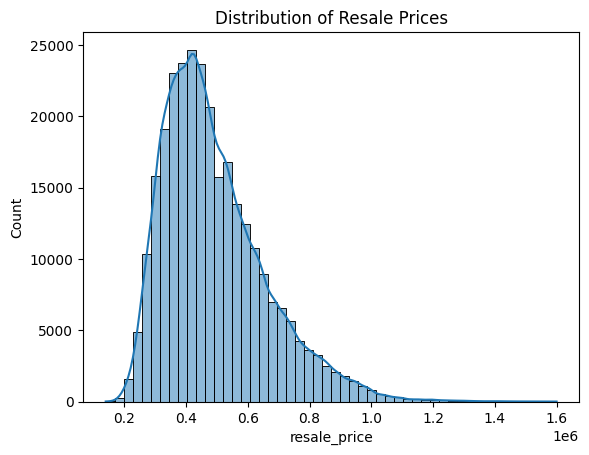

In [80]:
sns.histplot(hdb_final_df["resale_price"], bins=50, kde=True)
plt.title("Distribution of Resale Prices")
plt.show()

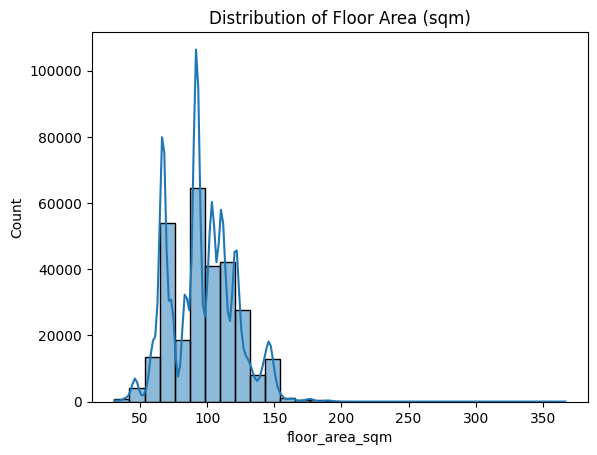

In [82]:
sns.histplot(hdb_final_df["floor_area_sqm"], bins=30, kde=True)
plt.title("Distribution of Floor Area (sqm)")
plt.show()


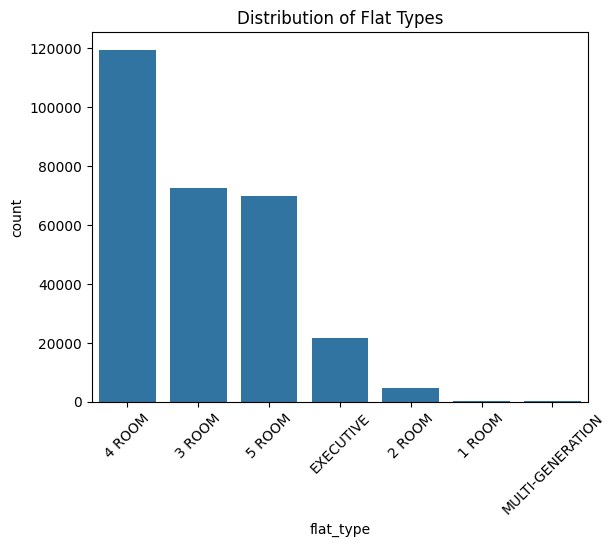

In [84]:
sns.countplot(x=hdb_final_df["flat_type"], order=hdb_final_df["flat_type"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Flat Types")
plt.show()


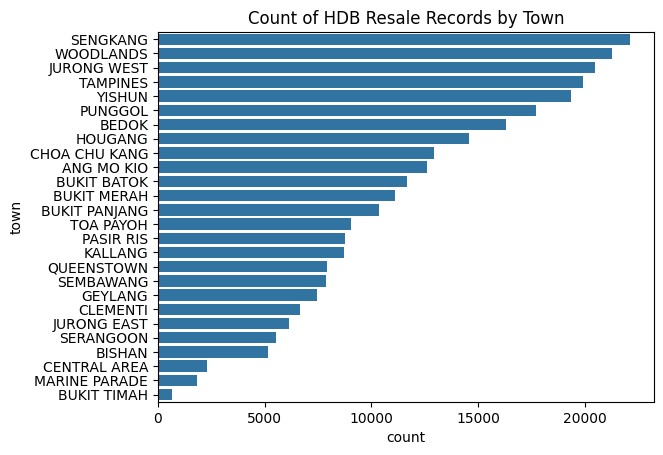

In [91]:

sns.countplot(y=hdb_final_df["town"], order=hdb_final_df["town"].value_counts().index)
plt.title("Count of HDB Resale Records by Town")
plt.show()


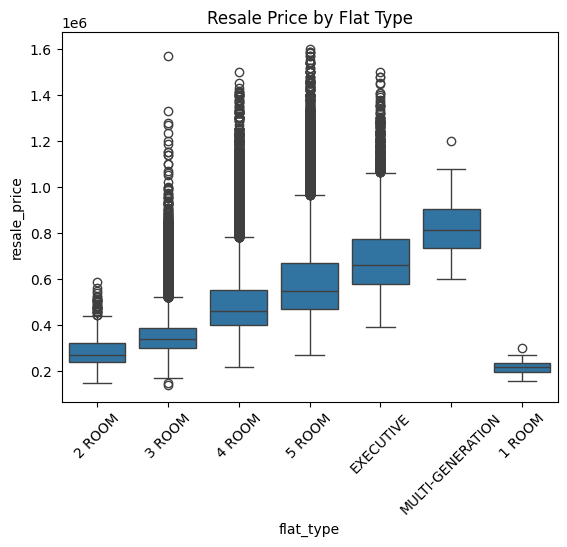

In [93]:
sns.boxplot(x="flat_type", y="resale_price", data=hdb_final_df)
plt.xticks(rotation=45)
plt.title("Resale Price by Flat Type")
plt.show()


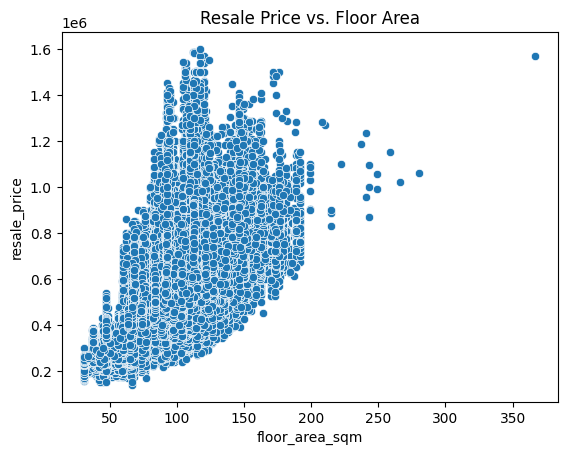

In [95]:
sns.scatterplot(x=hdb_final_df["floor_area_sqm"], y=hdb_final_df["resale_price"])
plt.title("Resale Price vs. Floor Area")
plt.show()


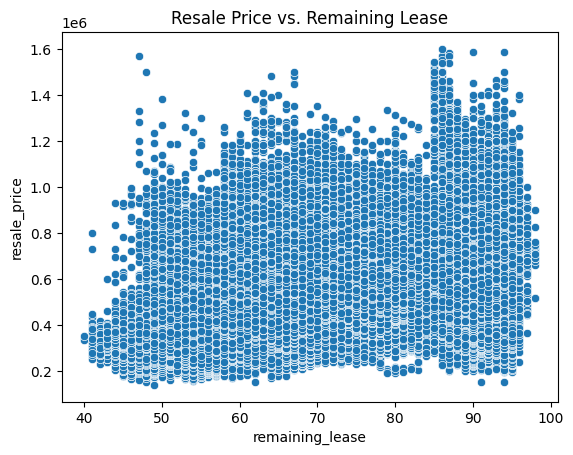

In [97]:
sns.scatterplot(x=hdb_final_df["remaining_lease"], y=hdb_final_df["resale_price"])
plt.title("Resale Price vs. Remaining Lease")
plt.show()


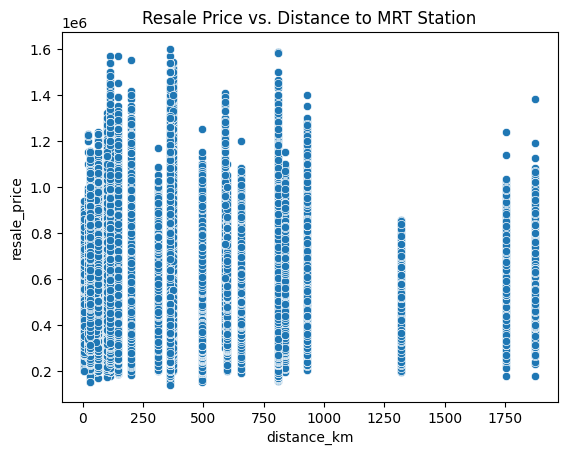

In [98]:
sns.scatterplot(x=hdb_final_df["distance_km"], y=hdb_final_df["resale_price"])
plt.title("Resale Price vs. Distance to MRT Station")
plt.show()


In [117]:
hdb_final_df_encoded = pd.get_dummies(hdb_final_df, columns=['town', 'flat_type', 'flat_model', 'station_name'], drop_first=True)
encoder = LabelEncoder()
hdb_final_df_encoded['storey_range'] = encoder.fit_transform(hdb_final_df_encoded['storey_range'])

hdb_final_df_encoded['latitude'] = hdb_final_df_encoded['latitude'].astype(float)
hdb_final_df_encoded['longitude'] = hdb_final_df_encoded['longitude'].astype(float)

hdb_final_df_encoded.drop(['block', 'street_name'], axis=1, inplace=True)

storey_mapping = {
    "01 TO 03": 2, "01 TO 05": 3, "04 TO 06": 5, "06 TO 10": 8, "07 TO 09": 8,
    "10 TO 12": 11, "11 TO 15": 13, "13 TO 15": 14, "16 TO 18": 17, "16 TO 20": 18,
    "19 TO 21": 20, "21 TO 25": 23, "22 TO 24": 23, "25 TO 27": 26, "26 TO 30": 28,
    "28 TO 30": 29, "31 TO 33": 32, "31 TO 35": 33, "34 TO 36": 35, "36 TO 40": 38,
    "37 TO 39": 38, "40 TO 42": 41, "43 TO 45": 44, "46 TO 48": 47, "49 TO 51": 50
}

hdb_final_df_encoded['storey_range'] = hdb_final_df_encoded['storey_range'].map(storey_mapping)



In [120]:
hdb_final_df_encoded.columns

Index(['month', 'storey_range', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease', 'latitude', 'longitude', 'distance_km',
       'resale_price', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK',
       'town_BUKIT MERAH', 'town_BUKIT PANJANG', 'town_BUKIT TIMAH',
       'town_CENTRAL AREA', 'town_CHOA CHU KANG', 'town_CLEMENTI',
       'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST', 'town_JURONG WEST',
       'town_KALLANG', 'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_2 ROOM', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION',
       'flat_model_3Gen', 'flat_model_Adjoined flat', 'flat_model_Apartment',
       'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improved-Maisonette', 'flat_model_Maisonette',
 